In [2]:
%matplotlib inline
from modsim import *

In [54]:
def make_system_coffee(T_init=90, r=0.01, volume=300, t_end=30):
    init = State(temp=T_init)
    
    system = System(init=init,
                    volume=volume,
                    r=r,
                    T_env=22, 
                    t0=0,
                    t_end=t_end,
                    dt=1)
    return system

def make_system_milk(T_init = 5, t_end = 30, r = 0.5, volume = 50):
    init = State(temp = T_init)
    system = System(init = init,
                    t0 = 0,
                    t_end = t_end,
                    r = r,
                    volume = volume,
                    T_env = 22,
                    dt = 1)
    return system

In [30]:
def update(state, system, t):
    unpack(system)
    if 5 < t < 30:
        T_amb = 0
    else:
        T_amb = T_env
    T = state.temp
    T += -r * (T - T_amb) * dt

    return State(temp=T)

In [31]:
def run_simulation(system, update_func):
    """Runs a simulation of the system.
    
    Add a TimeFrame to the System: results
    
    system: System object
    update_func: function that updates state
    """
    unpack(system)
    
    frame = TimeFrame(columns=init.index)
    frame.loc[t0] = init
    ts = linrange(t0, t_end-dt, dt)
    
    for t in ts:
        frame.loc[t+dt] = update_func(frame.loc[t], system, t)
    
    system.results = frame

In [32]:
coffee = make_system_coffee()
run_simulation(coffee, update)

In [24]:
coffee.results.temp[30]

67.584544488161882

In [37]:
def update(state, system, t, T_sweep):
    unpack(system)
    if 5 < t < 30:
        T_amb = T_sweep
    else:
        T_amb = T_env
    T = state.temp
    T += -r * (T - T_amb) * dt

    return State(temp=T)

In [38]:
def run_simulation_sweep(system, update_func):
    """Runs a simulation of the system.
    
    Add a TimeFrame to the System: results
    
    system: System object
    update_func: function that updates state
    """
    unpack(system)
    ts = linrange(t0, t_end-dt, dt)
    sweep = SweepSeries()
    for T_sweep in linrange(0, 21):
        frame = TimeFrame(columns=init.index)
        frame.loc[t0] = init
        for t in ts:
            frame.loc[t+dt] = update_func(frame.loc[t], system, t, T_sweep)
        sweep[T_sweep] = frame.temp[t_end]
    
    system.results = sweep

In [39]:
coffee = make_system_coffee()
run_simulation_sweep(coffee, update)

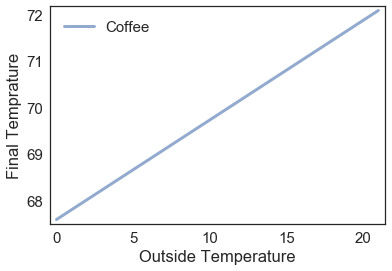

In [46]:
plot(coffee.results, label = 'Coffee')
decorate(xlabel = 'Outside Temperature',
         ylabel = 'Final Temprature',
         legend = 'True')

In [78]:
def run_and_mix(t_add, t_total=30):
    coffee = make_system(T_init=90, t_end=t_add, 
                         r=r_coffee, volume=300)
    run_simulation(coffee, update)

    milk = make_system(T_init=5, t_end=t_add, 
                       r=r_milk, volume=50)
    run_simulation(milk, update)
    
    mixture = mix(coffee, milk)
    mixture.t_end = t_total - t_add
    run_simulation(mixture, update)

    return final_temp(mixture)

def mix(s1, s2):
    assert s1.t_end == s2.t_end
    
    volume = s1.volume + s2.volume
    
    temp = (s1.volume * final_temp(s1) + 
            s2.volume * final_temp(s2)) / volume
    
    mixture = make_system(T_init=temp,
                          volume=volume,
                          r=s1.r,
                          t_end = s1.t_end)
    return mixture

def make_system(T_init=90, r=0.01, volume=300, t_end=30):
    init = State(temp=T_init)
    
    system = System(init=init,
                    volume=volume,
                    r=r,
                    T_env=22, 
                    t0=0,
                    t_end=t_end,
                    dt=1)
    return system

def final_temp(system):
    if hasattr(system, 'results'):
        return system.results.temp[system.t_end]
    else:
        return system.init.temp

In [89]:
def run_simulation_sweep(s1, s2, update_func):
    system = mix(s1, s2)
    unpack(system)
    ts = linrange(t0, t_end-dt, dt)
    sweep = SweepSeries()
    for T_sweep in linrange(0, 21):
        frame = TimeFrame(columns=init.index)
        frame.loc[t0] = init
        for t in ts:
            frame.loc[t+dt] = update_func(frame.loc[t], system, t, T_sweep)
        sweep[T_sweep] = frame.temp[t_end]
    
    return sweep

In [90]:
milk = make_system_milk()
coffee = make_system_coffee()

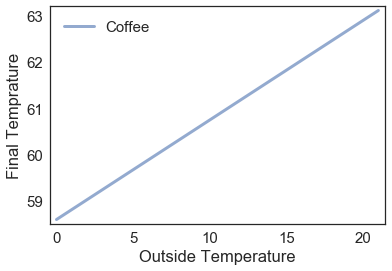

In [91]:
plot(run_simulation_sweep(coffee, milk, update), label = 'Coffee')
decorate(xlabel = 'Outside Temperature',
         ylabel = 'Final Temprature',
         legend = True)